In [30]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [31]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [32]:
import numpy as np
import matplotlib.pyplot as pl
from corner import hist2d
from astropy.table import Table

# An Interactive Introduction to Supervised Learning
## Pierre Gratier
### Laboratoire d'Astrophysique de Bordeaux

<br>
<div align="left">
<img src="images/logo_3DICE.png" style="width:200px"/>
<img src="images/vignette-lab.png" style="width:200px" />
</div>



# Machine learning 
0. Choose a quantity to optimize. For regression, one of:
     - Mean squared errors
     - Median absolute deviation
1. Train
     - Use a large fraction of the dataset (the larger, and more diverse, the better)
2. Validate hyperparameters
     - make sure not to overtrain
     - cross validation (eg train on 2/3 of training set, test on 1/3. Repeat 3 times)
3. Test
     - On *previously unseen* data
4. (interpret)

# But train with what ???

Whatever you want !

- linear models
- polynomials
- neural networks
- ...

# Supervised machine learning

Predict an output property knowning a set of input parameters
 - if property is discrete : classification
 - if property is continuous : regression 
 
![regression_tools.png](images/regression_tools.jpeg)

# Spoiler: we've been doing machine learning for quite some time 

In [33]:
from sklearn.linear_model import LinearRegression

def linfunc(x):
    return 2*x+3

def nonlinfunc(x):
    return np.sinc(x)

def create_trainset(f, ntrain=20,ntest=1000,noise=0.,seed=1234):
    np.random.seed(seed)
    xmin, xmax = -3, 3
    x_true = np.linspace(xmin-2,xmax+2,ntest)
    x_train = np.random.uniform(xmin, xmax, ntrain)
    y_true = f(x_true)
    y_train = f(x_train)
    y_train += np.random.normal(0,noise,ntrain)
    return x_train, y_train, x_true, y_true

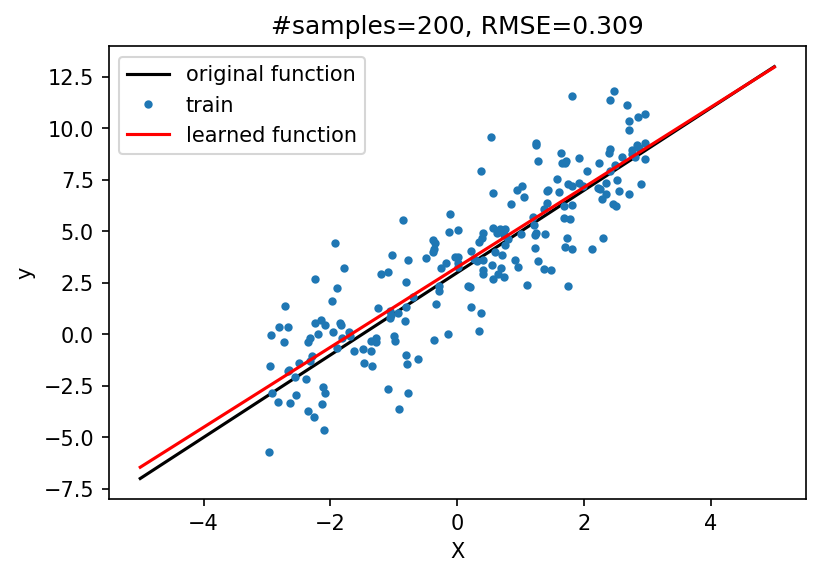

In [34]:
xtrain, ytrain, xtest, ytrue = create_trainset(linfunc, ntrain=200,ntest=1000,noise=2)
pl.plot(xtest,ytrue,'k-',label="original function")
pl.plot(xtrain,ytrain,'C0.',label='train')
reg_eg = LinearRegression()
reg_eg.fit(xtrain.reshape(-1,1), ytrain)
pred = reg_eg.predict(xtest.reshape(-1,1))
pl.plot(xtest,pred,'r-',label='learned function')
rmse = np.sqrt(((ytrue-pred)**2).mean())
pl.title("#samples={}, RMSE={:5.3f}".format(len(xtrain), rmse))
pl.legend(loc='upper left')
pl.xlabel("X")
pl.ylabel("y")
pl.show()

# Decision Trees
<br>
<div align="left">
<img src="images/Treebeard.png.jpeg" style="width:600px"/>
</div>


# Decision Trees
 - non linear machine learning algorithm
 - Can be used for classification or regression
 - Don't need to "prepare" (eg normalise, reparametrize) data
<br>
<div align="left">
<img src="images/decisiontree.gif" style="width:600px"/>
</div>

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def plot_depth(idepth, **kwargs):
    pl.plot(xtest,ytrue,'k-',label="original function")
    pl.plot(xtrain,ytrain,'C0.',label='train')
    reg_eg = DecisionTreeRegressor(max_depth=idepth)
    reg_eg.fit(xtrain.reshape(-1,1), ytrain)
    pred = reg_eg.predict(xtest.reshape(-1,1))
    pl.plot(xtest,pred,'r-',label='learned function')
    rmse = np.sqrt(((ytrue-pred)**2).mean())
    pl.title("#samples={}, max depth={}, RMSE={:5.3f}".format(len(xtrain),idepth, rmse))
    pl.legend(loc='upper left')
    pl.xlabel("X")
    pl.ylabel("y")
    pl.show()

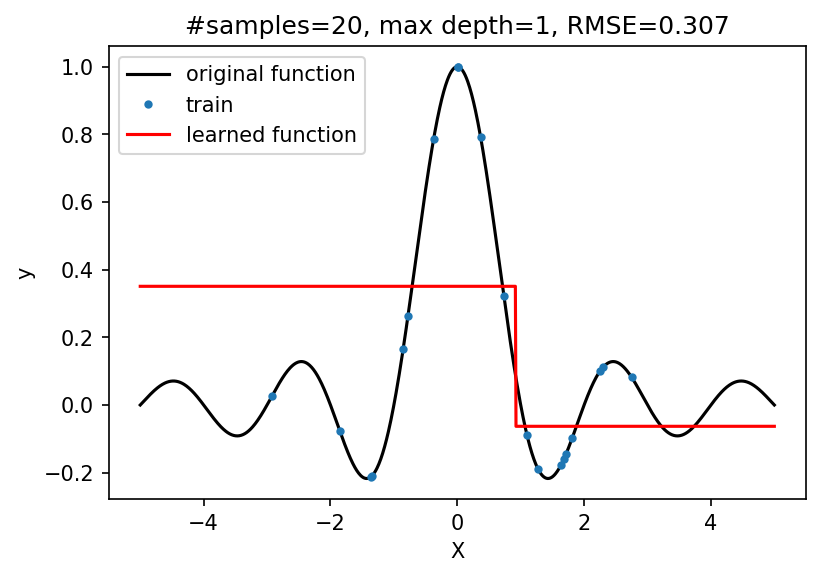

In [36]:
np.random.seed(1234)
xtrain, ytrain, xtest, ytrue = create_trainset(nonlinfunc)
plot_depth(1)

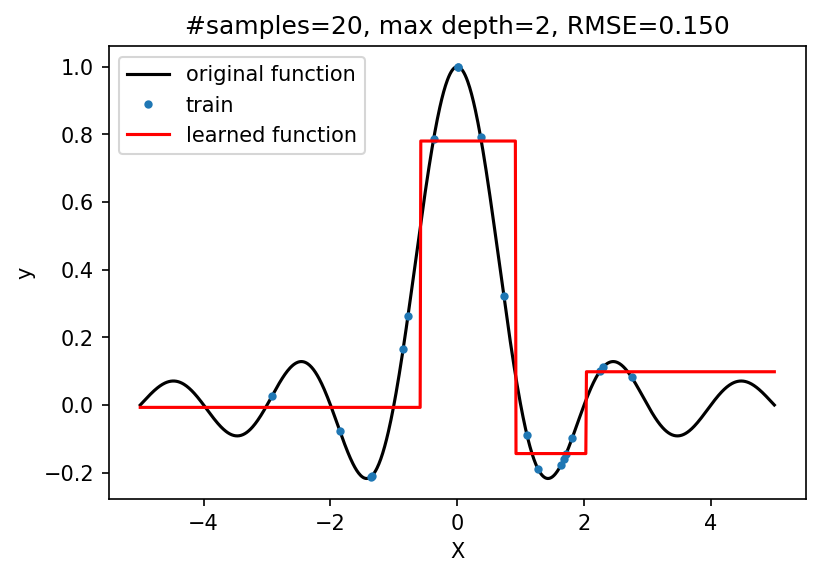

In [37]:
plot_depth(2)

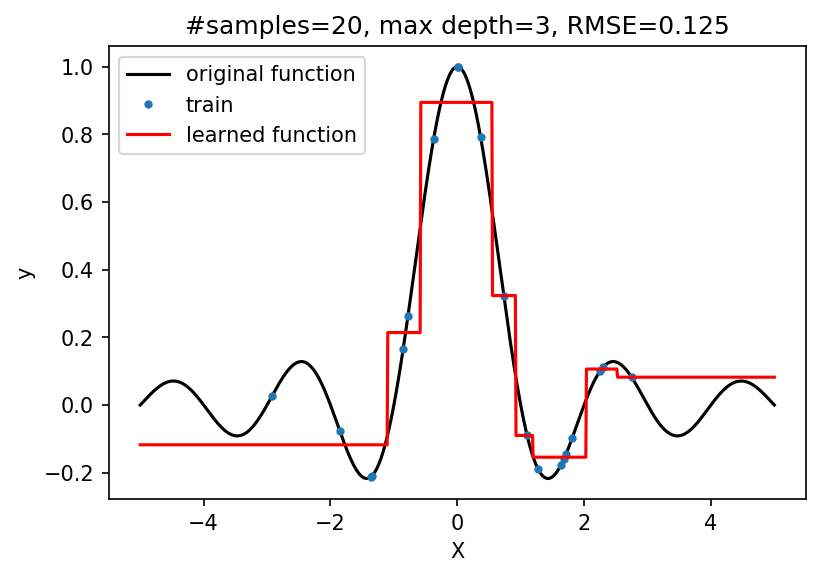

In [38]:
plot_depth(3)

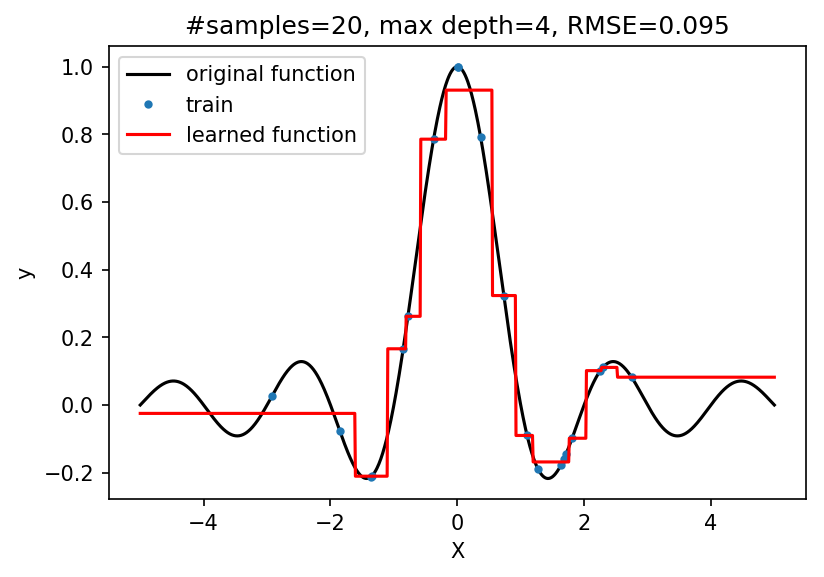

In [39]:
plot_depth(4)

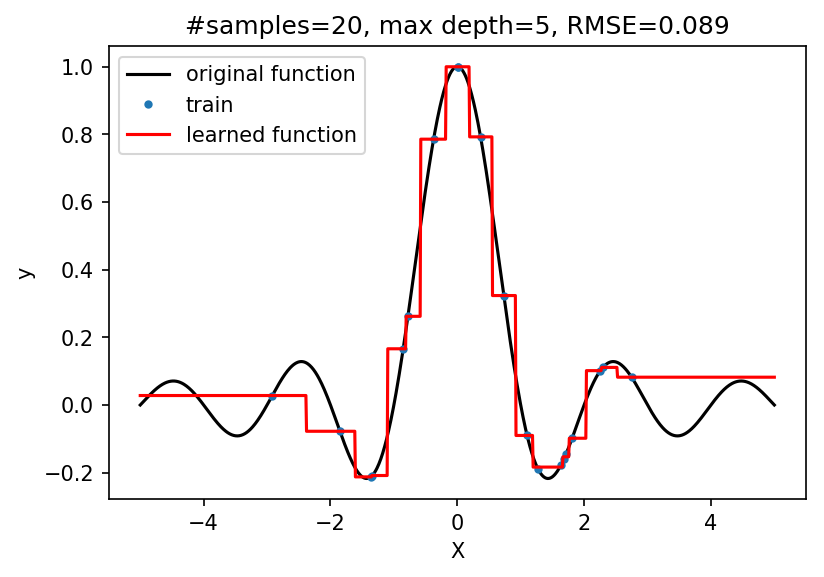

In [40]:
plot_depth(5)

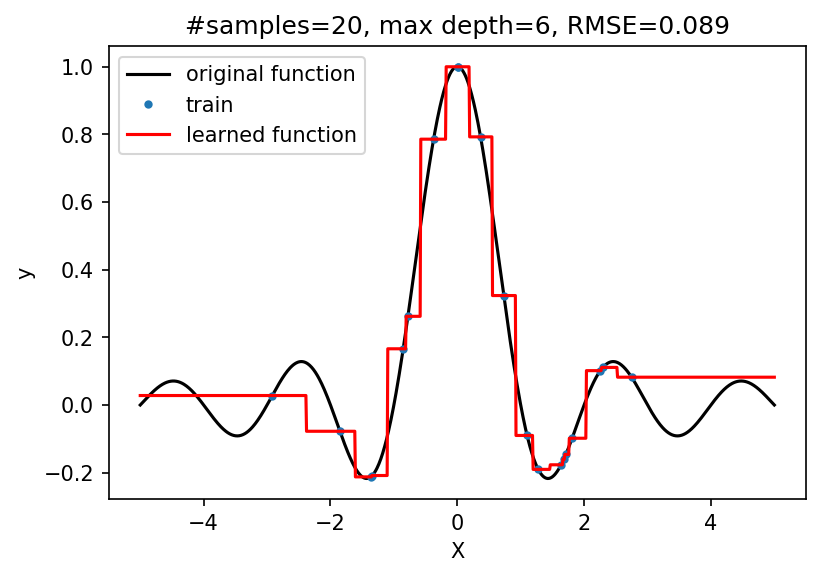

In [41]:
plot_depth(6)

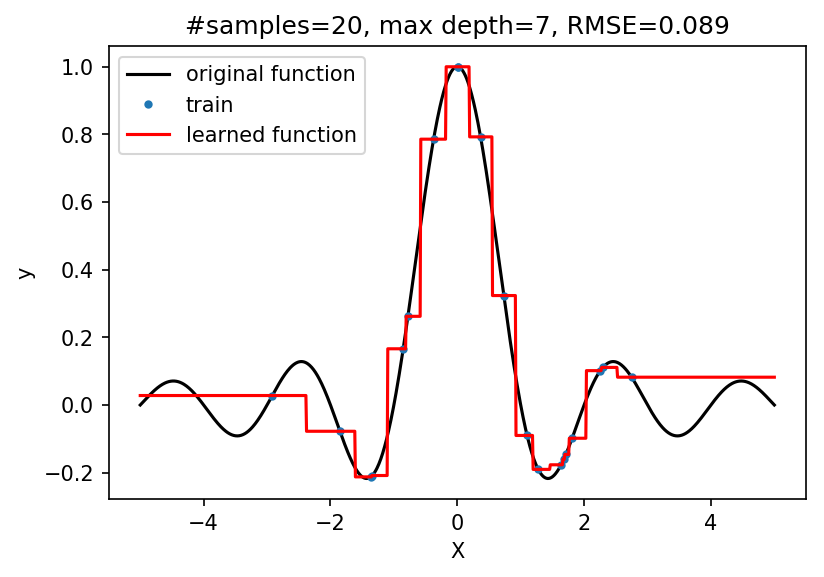

In [42]:
plot_depth(7)

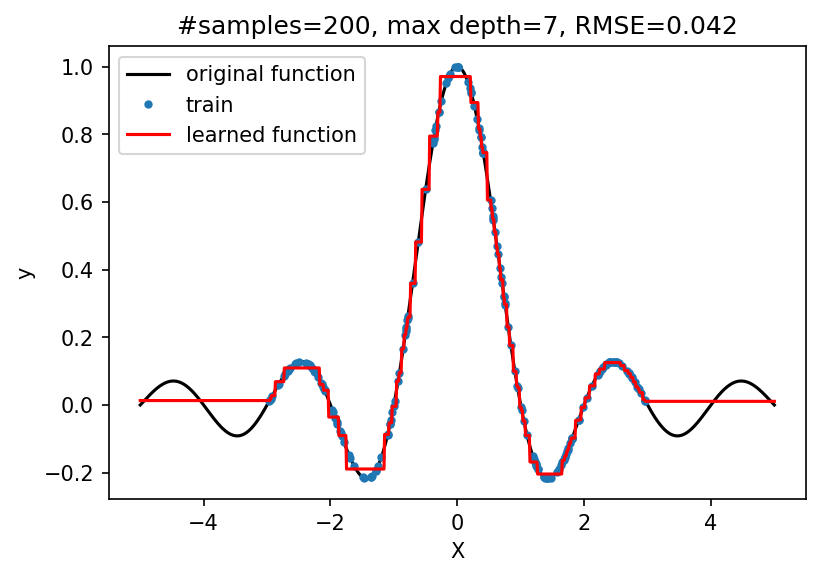

In [43]:
np.random.seed(1234)
xtrain, ytrain, xtest, ytrue = create_trainset(nonlinfunc,ntrain=200)
plot_depth(7)

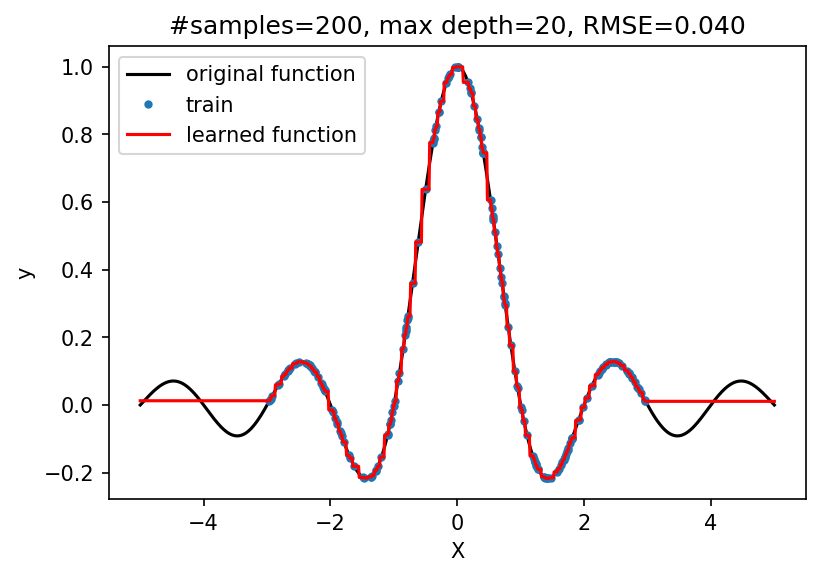

In [44]:
plot_depth(20)

# What about noise ?

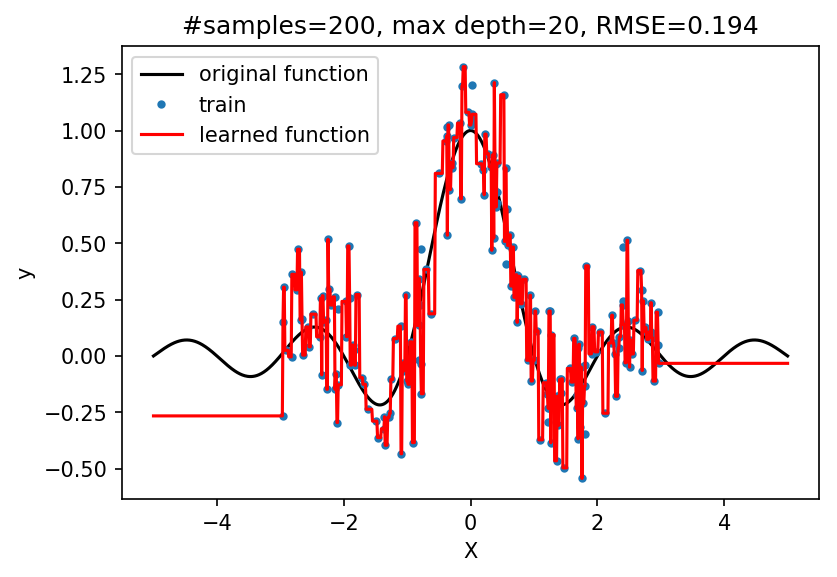

In [45]:
np.random.seed(1234)
xtrain, ytrain, xtest, ytrue = create_trainset(nonlinfunc,ntrain=200, noise=0.2)
plot_depth(20)

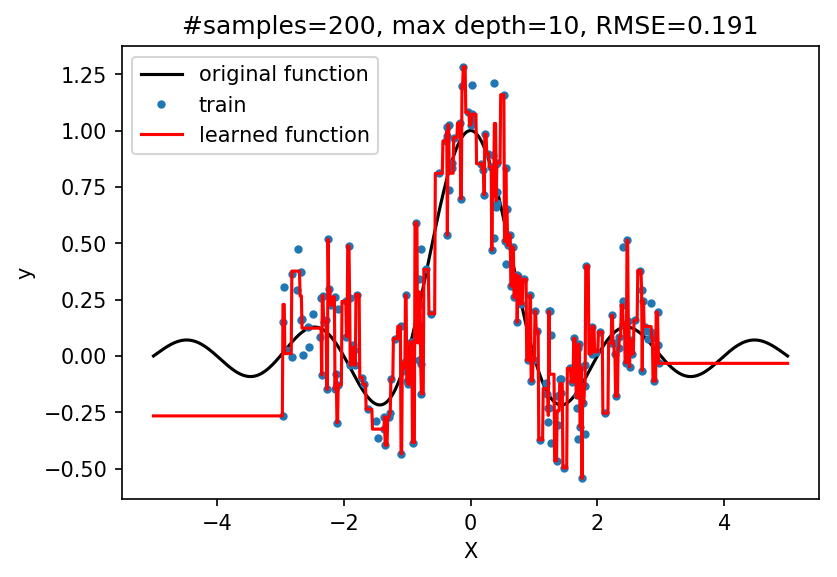

In [46]:
plot_depth(10)

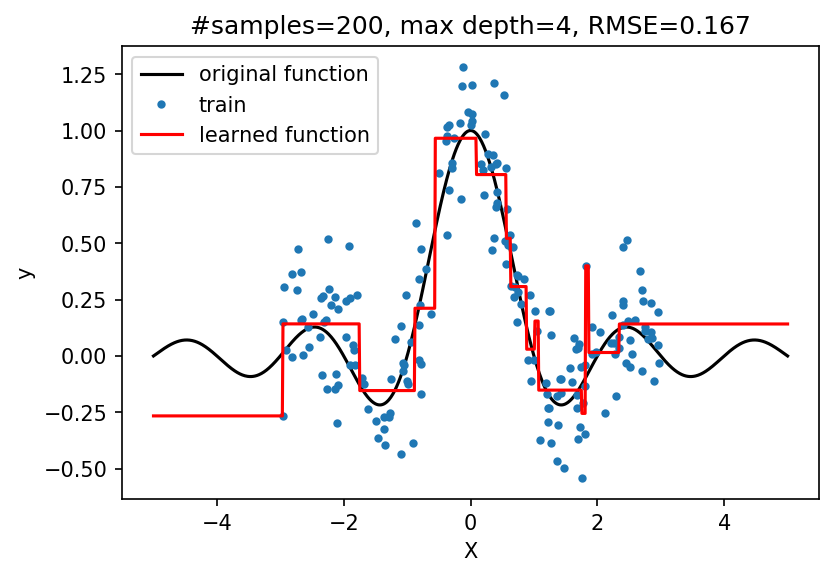

In [47]:
plot_depth(4)

# You enter the forest ... 
<br>
<div align="left">
<img src="images/forest.jpg" style="width:600px"/>
</div>

# The Random Forest
Idea:
 - train a bunch of weaker trees on random subsets of the data
     - less deep
     - only considering a subset of the features
     - ** to minimise sensitivity to overtraining**
 - average their results out 
 
Generalised to bagging methods (="bootstrap aggreggating")
 - a lot of "weak" learners can be bagged


In [48]:
def plot_depth_random_forest(idepth):
    pl.plot(xtest,ytrue,'k-',label="original function")
    pl.plot(xtrain,ytrain,'C0.',label='train')
    rf = RandomForestRegressor(500,max_depth=idepth)
    rf.fit(xtrain.reshape(-1,1), ytrain)
    pred = rf.predict(xtest.reshape(-1,1))
    for tree in rf.estimators_[:100]:
        pl.plot(xtest,tree.predict(xtest.reshape(-1,1)),'C1-',alpha=0.1)
    pl.plot(xtest,tree.predict(xtest.reshape(-1,1)),'C1-',alpha=0.1,label='individual trees')
    pl.plot(xtest,pred,'r-',label='average of trees')
    rmse = np.sqrt(((ytrue-pred)**2).mean())
    pl.title("#samples={}, max depth={}, RMSE={:5.3f}".format(len(xtrain),idepth, rmse))
    pl.xlabel("X")
    pl.ylabel("y")
    pl.legend(loc='upper left')

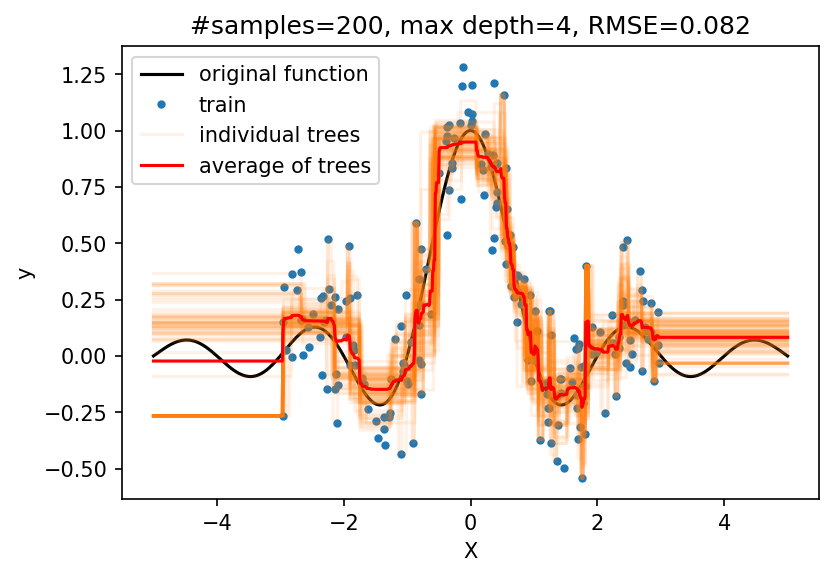

In [49]:
plot_depth_random_forest(4)

# Photometric reshift example

Estimate redshift of a galaxie without having to record a full spectrum

**Photometric redshifts for the SDSS Data Release 12** 

*Robert Beck; Laszlo Dobos; Tamas Budavari; Alexander S. Szalay; Istvan Csabai*

Monthly Notices of the Royal Astronomical Society 2016 460 (2): 1371-1381

doi: 10.1093/mnras/stw1009

http://www.vo.elte.hu/papers/2016/photoz/


In [50]:
t = Table.read('data/dataset.dat', format='ascii.commented_header')
X = np.array([t['r_mag'], t['(u-g)'], t['(g-r)'], t['(r-i)'], t['(i-z)']]).T
y = np.array(t['specz'])
t

objID,r_mag,(u-g),(g-r),(r-i),(i-z),specz,specz_err,r_mag_err,(u-g)_err,(g-r)_err,(r-i)_err,(i-z)_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1237645879573873373,20.103556,0.61777878,1.5659828,0.80243492,0.34698868,0.50467163,0.00020466947,0.12190636211279779,0.7569993424418415,0.1856641077267804,0.08918345792766323,0.16939028255106794
1237645941824356668,19.704782,1.289072,1.1333313,0.51053619,0.41262436,0.36670265,6.5150554e-05,0.0655080060003986,0.33961256317629146,0.05978348297217164,0.0364401446169884,0.06327843123851273
1237645942898230100,20.193981,0.65864944,1.6796875,0.97254181,0.42072105,0.51120573,9.6673393e-05,0.06894538211721137,0.4696232662930288,0.13246810970813222,0.04741867468974273,0.07219557530687769
1237645943434969247,17.664146,2.3386784,1.3168621,0.52295685,0.30891609,0.2178527,2.8101276e-05,0.034146275497393484,0.2086004253407079,0.017263574133549436,0.010426318102097713,0.016662031474130867
1237645943973609779,20.679634,2.8722134,1.285862,0.78954506,0.42936516,0.53021437,0.00012953312,0.08482012218868118,0.9404929344359603,0.14391915658624657,0.07034844106473559,0.10070183666858297
1237646586638631776,17.648102,1.2305584,0.77993202,0.39781952,0.19709969,0.12130364,1.3130572e-05,0.04140241865153553,0.2656704256725191,0.03141473544805958,0.020330210959204627,0.036698848342571165
1237646586638696975,17.390694,1.8147697,0.99510956,0.45385933,0.34827614,0.12077779,2.1676848e-05,0.0404870914021047,0.4983410051472198,0.03283435383999303,0.018127467166179162,0.027556321567178722
1237646586639287212,18.276638,0.63219833,1.3370743,0.44069099,0.32370758,0.27851638,3.7723737e-05,0.09077032654908011,1.2388604557839884,0.17696659585781443,0.06197666372981022,0.09387934854518722
1237646587173340066,17.29701,1.1269169,0.68570518,0.26628304,0.2367115,0.15302545,3.2831675e-05,0.04995095286032848,0.08662077996581817,0.017630657351227326,0.016086336565440434,0.03967631810790787


# Some terminology
The 4 columns r_mag, (u-g), (g-r), (r-i), (i-z) are called **features**

specz is the predicted quantity

A line of the table is a **sample**

Here we try to predict 1 quantity from 5 features using 1065891 samples 

# Having a look at the data

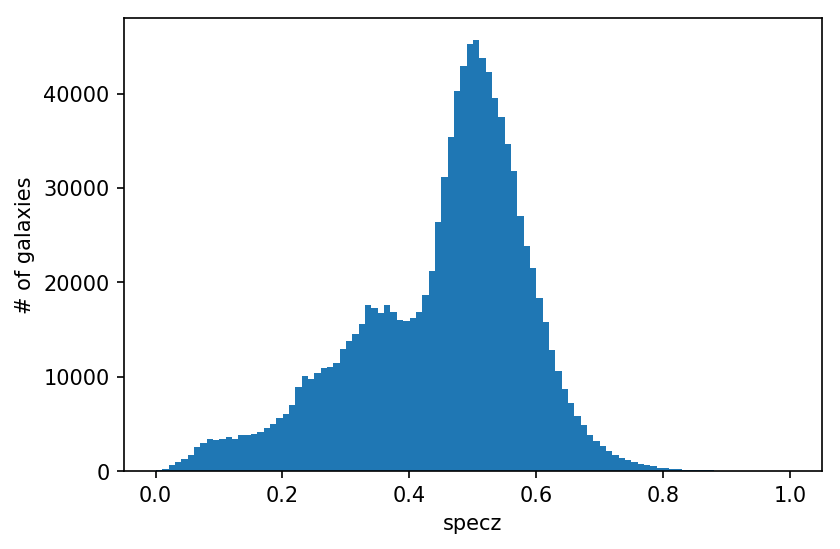

In [51]:
pl.hist(y, bins=100)
pl.xlabel('specz')
pl.ylabel('# of galaxies')
pl.show()

# Having a look at the data

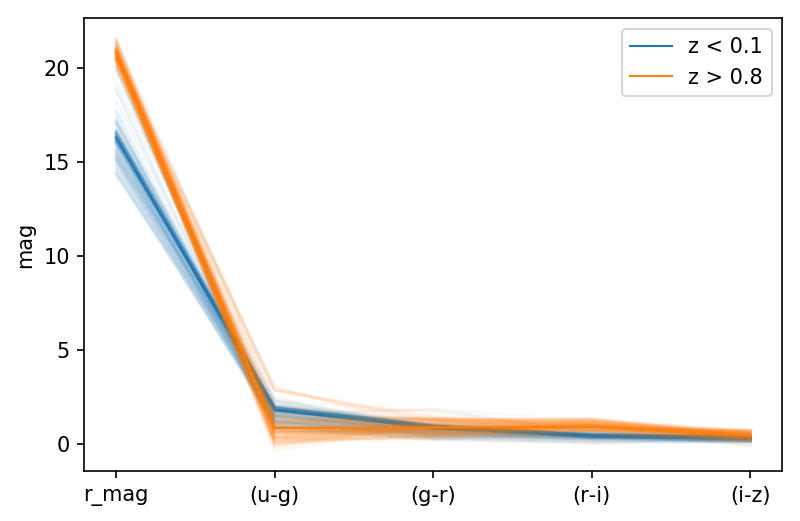

In [52]:
#low z
lowz = X[y<0.1]
for z in lowz[:100]:
    pl.plot(z,'C0',alpha=0.05)
pl.plot(np.mean(lowz,0),'C0',lw=1,label='z < 0.1')
#high z
highz = X[y>0.8]
for z in highz[:100]:
    pl.plot(z,'C1',alpha=0.05)
pl.plot(np.mean(highz,0),'C1',lw=1,label='z > 0.8')
pl.ylabel('mag')
pl.xticks([0,1,2,3,4],t.colnames[1:])
pl.xticks
pl.legend()
pl.show()

# Check a linear model to have a benchmark for the improvement

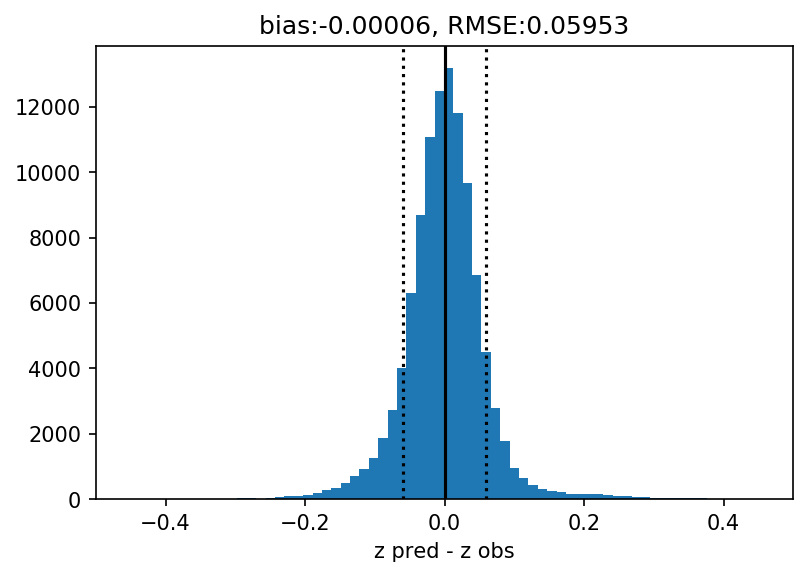

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
np.random.seed(1234)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)

reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

diff = y_pred-y_test
bias = np.mean(diff)
rmse = np.sqrt(np.mean(diff**2))
rmse_linear = rmse.copy()

pl.hist(diff, bins=100)
pl.axvline(bias,color='k')
pl.axvline(bias-rmse,color='k',ls=':')
pl.axvline(bias+rmse,color='k',ls=':')
pl.xlim([-0.5,0.5])
pl.xlabel("z pred - z obs")
pl.title("bias:{:6.5f}, RMSE:{:4.5f}".format(bias, rmse))
pl.show()

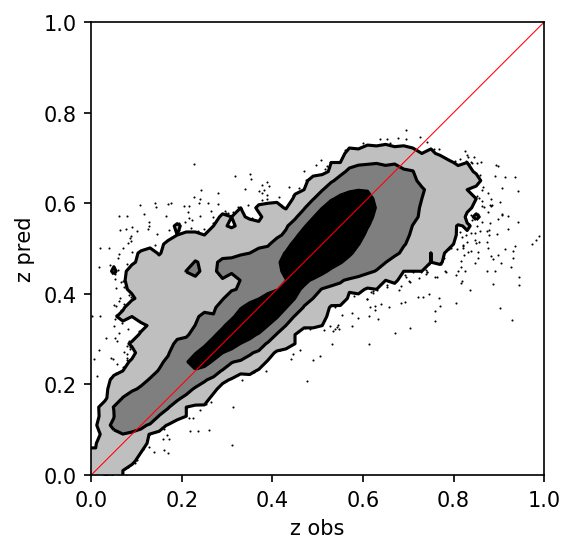

In [104]:
fig, ax = pl.subplots()
hist2d(y_test,y_pred,bins=50,ax=ax,range=[[0,1],[0,1]],levels=[0.68,0.95,0.997],plot_density=False,fill_contours=True,data_kwargs={'alpha':1,'marker':'.'})
ax.set_aspect('equal')
ax.set_ylabel("z pred")
ax.set_xlabel("z obs")
pl.plot([0,1],[0,1],'r-',lw=0.5)
pl.show()

# Out of the box random forest 

CPU times: user 2min 26s, sys: 998 ms, total: 2min 27s
Wall time: 26.9 s
CPU times: user 1.93 s, sys: 354 ms, total: 2.28 s
Wall time: 415 ms


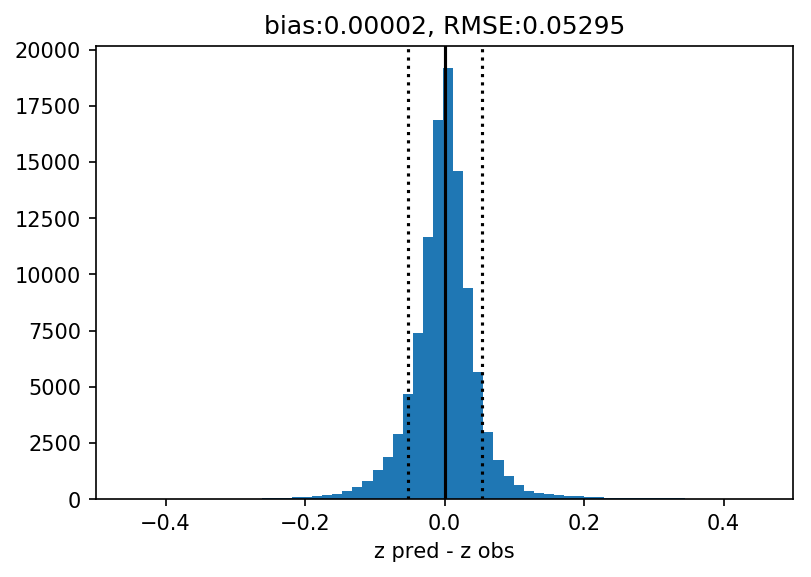

In [105]:
np.random.seed(1234)
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(n_jobs=8, random_state=1234)

%time fit = rf.fit(X_train, y_train)
%time y_pred = rf.predict(X_test)

diff = y_pred-y_test
bias = np.mean(diff)
rmse = np.sqrt(np.mean(diff**2))
rmse_default = rmse.copy()

pl.hist(diff, bins=100)
pl.axvline(bias,color='k')
pl.axvline(bias-rmse_default,color='k',ls=':')
pl.axvline(bias+rmse_default,color='k',ls=':')
pl.xlim([-0.5,0.5])
pl.xlabel("z pred - z obs")
pl.title("bias:{:6.5f}, RMSE:{:4.5f}".format(bias, rmse_default))
pl.show()

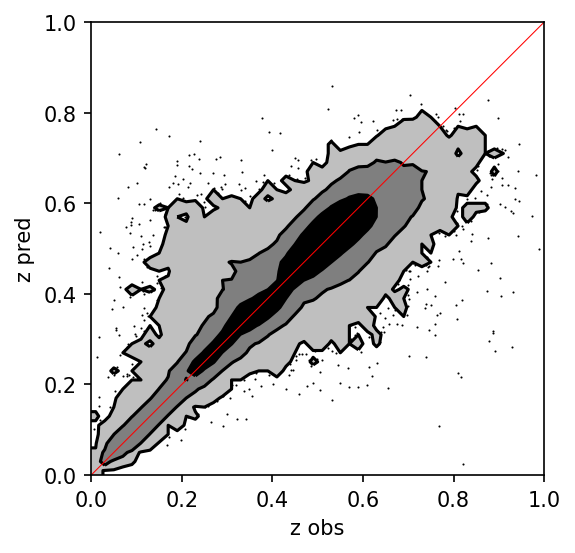

In [106]:
fig, ax = pl.subplots()
hist2d(y_test,y_pred,bins=50,ax=ax,range=[[0,1],[0,1]],levels=[0.68,0.95,0.997],plot_density=False,fill_contours=True,data_kwargs={'alpha':1,'marker':'.'})
ax.set_aspect('equal')
ax.set_ylabel("z pred")
ax.set_xlabel("z obs")
pl.plot([0,1],[0,1],'r-',lw=0.5)
pl.show()

# Results 
A full 11.2% improvement of the root mean squared error FTW !!


In [107]:
print("A full {:5.2f}% improvement of the root mean squared error FTW !!".format(100*(1-rmse_default/rmse_linear)))

A full 11.05% improvement of the root mean squared error FTW !!


But there are a lot of parameters of the random forest we should be able to tweak !

In [108]:
for key, value in rf.get_params().items():
    print("{:<30}:{}".format(key, value))

bootstrap                     :True
criterion                     :mse
max_depth                     :None
max_features                  :auto
max_leaf_nodes                :None
min_impurity_decrease         :0.0
min_impurity_split            :None
min_samples_leaf              :1
min_samples_split             :2
min_weight_fraction_leaf      :0.0
n_estimators                  :10
n_jobs                        :8
oob_score                     :False
random_state                  :1234
verbose                       :0
warm_start                    :False


# How do we choose the best values ?
### Cross validation 

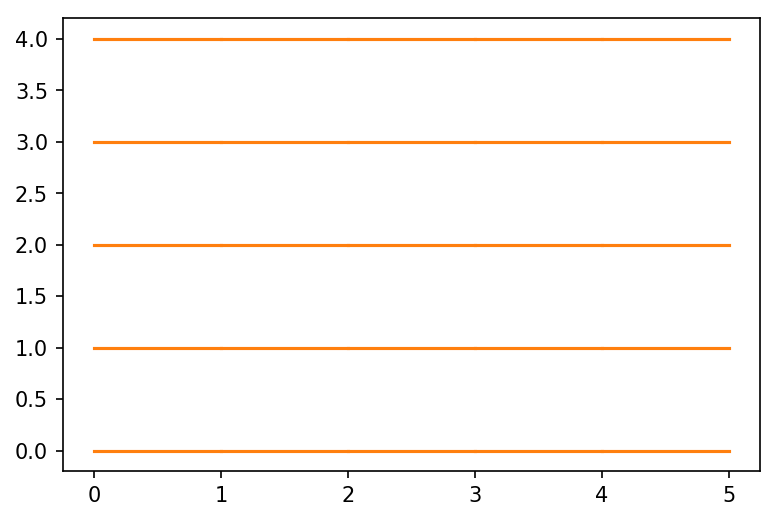

In [109]:
fig, ax = pl.subplots(1)
y_pos = 0
x_pos = np.arange(5)
for j in range(5):
    for i in range(5):
        pl.plot([x_pos[i],x_pos[i]+1],[j,j],color='C1')

# An obvious parameter: `n_estimators`

In [59]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {
   'n_estimators': list(map(int,np.logspace(1,2.3,5))), 
  },
 ]
GridSearchRF = GridSearchCV(rf,param_grid,scoring='neg_mean_squared_error',cv=5,verbose=0,n_jobs=8,return_train_score=True)
out = GridSearchRF.fit(X_train[:10000], y_train[:10000])

In [60]:
GridSearchRF.cv_results_
param = GridSearchRF.cv_results_['param_n_estimators'].data
mean_time = GridSearchRF.cv_results_['mean_fit_time']
std_time = GridSearchRF.cv_results_['std_fit_time']
mean_train = GridSearchRF.cv_results_['mean_train_score']
mean_test = GridSearchRF.cv_results_['mean_test_score']
std_train = GridSearchRF.cv_results_['std_train_score']
std_test = GridSearchRF.cv_results_['std_test_score']

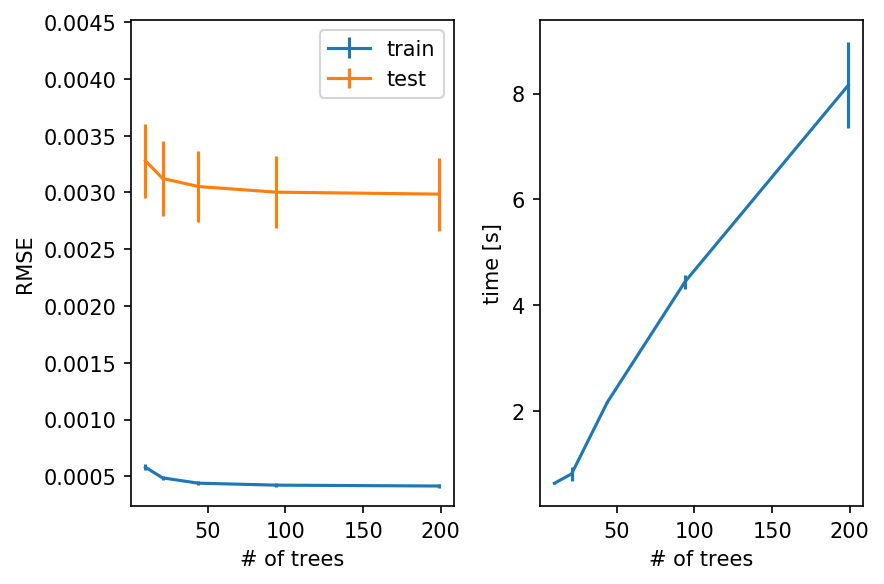

In [61]:
fig,ax = pl.subplots(1,2)
ax[0].errorbar(param,-mean_train,std_train,label='train')
ax[0].errorbar(param,-mean_test,std_test,label='test')
ax[0].legend()
ax[0].set_xlabel('# of trees')
ax[0].set_ylabel('RMSE')
ax[0].set_ylim(ymax=1.2*ax[0].get_ylim()[1])
ax[1].errorbar(param,mean_time,std_time)
ax[1].set_ylabel('time [s]')
ax[1].set_xlabel('# of trees')
pl.tight_layout()

In [73]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {
   'max_features': [1, 2, 3, 4, 5], 
   'max_depth': list(range(1,20,2))
  },
 ]
rf.set_params(n_estimators=10)
GridSearchRF = GridSearchCV(rf,param_grid,scoring='neg_mean_squared_error',cv=5,verbose=0,n_jobs=8,return_train_score=True,refit=False)
out = GridSearchRF.fit(X_train, y_train)
best_params = out.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] max_depth=1, max_features=1 .....................................
[CV] max_depth=1, max_features=1 .....................................
[CV] max_depth=1, max_features=1 .....................................
[CV] max_depth=1, max_features=1 .....................................
[CV] max_depth=1, max_features=1 .....................................
[CV] max_depth=1, max_features=2 .....................................
[CV] max_depth=1, max_features=2 .....................................
[CV] ...................... max_depth=1, max_features=1, total=   1.9s
[CV] max_depth=1, max_features=2 .....................................
[CV] ...................... max_depth=1, max_features=1, total=   2.3s
[CV] max_depth=1, max_features=2 .....................................
[CV] ...................... max_depth=1, max_features=1, total=   2.5s
[CV] max_depth=1, max_features=2 .....................................
[CV] ..........

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   27.1s


[CV] max_depth=3, max_features=2 .....................................
[CV] ...................... max_depth=1, max_features=5, total=  10.0s
[CV] max_depth=3, max_features=2 .....................................
[CV] ...................... max_depth=3, max_features=1, total=   8.5s
[CV] max_depth=3, max_features=2 .....................................
[CV] ...................... max_depth=3, max_features=1, total=   8.4s
[CV] max_depth=3, max_features=3 .....................................
[CV] ...................... max_depth=3, max_features=1, total=   8.4s
[CV] max_depth=3, max_features=3 .....................................
[CV] ...................... max_depth=3, max_features=1, total=   9.0s
[CV] max_depth=3, max_features=3 .....................................
[CV] ...................... max_depth=3, max_features=2, total=  14.2s
[CV] max_depth=3, max_features=3 .....................................
[CV] ...................... max_depth=3, max_features=2, total=  14.2s
[CV] m

[CV] max_depth=7, max_features=4 .....................................
[CV] ...................... max_depth=7, max_features=2, total=  30.7s
[CV] max_depth=7, max_features=4 .....................................
[CV] ...................... max_depth=7, max_features=2, total=  31.6s
[CV] max_depth=7, max_features=4 .....................................
[CV] ...................... max_depth=7, max_features=3, total=  43.2s
[CV] max_depth=7, max_features=4 .....................................
[CV] ...................... max_depth=7, max_features=3, total=  42.7s
[CV] max_depth=7, max_features=4 .....................................
[CV] ...................... max_depth=7, max_features=3, total=  42.6s
[CV] max_depth=7, max_features=5 .....................................
[CV] ...................... max_depth=7, max_features=3, total=  41.7s
[CV] max_depth=7, max_features=5 .....................................
[CV] ...................... max_depth=7, max_features=3, total=  41.9s
[CV] m

[CV] max_depth=11, max_features=5 ....................................
[CV] ..................... max_depth=11, max_features=4, total= 1.2min
[CV] max_depth=11, max_features=5 ....................................
[CV] ..................... max_depth=11, max_features=4, total= 1.2min
[CV] max_depth=13, max_features=1 ....................................
[CV] ..................... max_depth=11, max_features=4, total= 1.2min
[CV] max_depth=13, max_features=1 ....................................
[CV] ..................... max_depth=13, max_features=1, total=  26.2s
[CV] max_depth=13, max_features=1 ....................................
[CV] ..................... max_depth=11, max_features=4, total= 1.2min
[CV] max_depth=13, max_features=1 ....................................


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 10.5min


[CV] ..................... max_depth=11, max_features=5, total= 1.4min
[CV] max_depth=13, max_features=1 ....................................
[CV] ..................... max_depth=13, max_features=1, total=  22.4s
[CV] max_depth=13, max_features=2 ....................................
[CV] ..................... max_depth=13, max_features=1, total=  22.1s
[CV] max_depth=13, max_features=2 ....................................
[CV] ..................... max_depth=11, max_features=5, total= 1.4min
[CV] max_depth=13, max_features=2 ....................................
[CV] ..................... max_depth=13, max_features=1, total=  20.5s
[CV] max_depth=13, max_features=2 ....................................
[CV] ..................... max_depth=11, max_features=5, total= 1.4min
[CV] max_depth=13, max_features=2 ....................................
[CV] ..................... max_depth=13, max_features=1, total=  25.3s
[CV] max_depth=13, max_features=3 ....................................
[CV] .

[CV] ..................... max_depth=15, max_features=5, total= 1.7min
[CV] max_depth=17, max_features=3 ....................................
[CV] ..................... max_depth=17, max_features=2, total=  49.7s
[CV] max_depth=17, max_features=3 ....................................
[CV] ..................... max_depth=17, max_features=2, total=  50.7s
[CV] max_depth=17, max_features=3 ....................................
[CV] ..................... max_depth=17, max_features=2, total=  51.9s
[CV] max_depth=17, max_features=4 ....................................
[CV] ..................... max_depth=17, max_features=2, total=  53.5s
[CV] max_depth=17, max_features=4 ....................................
[CV] ..................... max_depth=17, max_features=2, total=  54.0s
[CV] max_depth=17, max_features=4 ....................................
[CV] ..................... max_depth=17, max_features=3, total= 1.2min
[CV] max_depth=17, max_features=4 ....................................
[CV] .

[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed: 25.4min finished


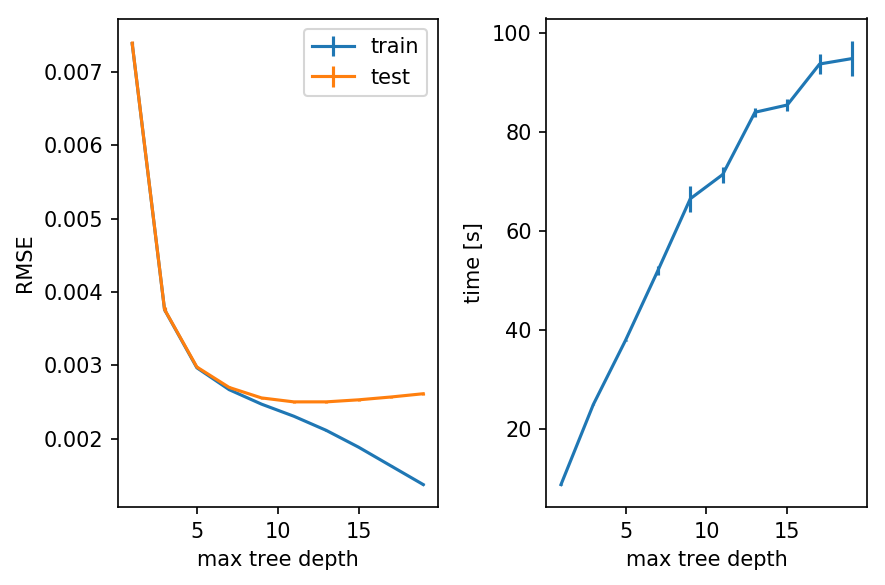

In [110]:
param = np.unique(GridSearchRF.cv_results_['param_max_depth'].data)
mean_time = GridSearchRF.cv_results_['mean_fit_time'].reshape(-1,5)[:,3]
std_time = GridSearchRF.cv_results_['std_fit_time'].reshape(-1,5)[:,3]
mean_train = GridSearchRF.cv_results_['mean_train_score'].reshape(-1,5)[:,3]
mean_test = GridSearchRF.cv_results_['mean_test_score'].reshape(-1,5)[:,3]
std_train = GridSearchRF.cv_results_['std_train_score'].reshape(-1,5)[:,3]
std_test = GridSearchRF.cv_results_['std_test_score'].reshape(-1,5)[:,3]

fig,ax = pl.subplots(1,2)
ax[0].errorbar(param,-mean_train,std_train,label='train')
ax[0].errorbar(param,-mean_test,std_test,label='test')
ax[0].legend()
ax[0].set_xlabel('max tree depth')
ax[0].set_ylabel('RMSE')
ax[1].errorbar(param,mean_time,std_time)
ax[1].set_ylabel('time [s]')
ax[1].set_xlabel('max tree depth')
pl.tight_layout()

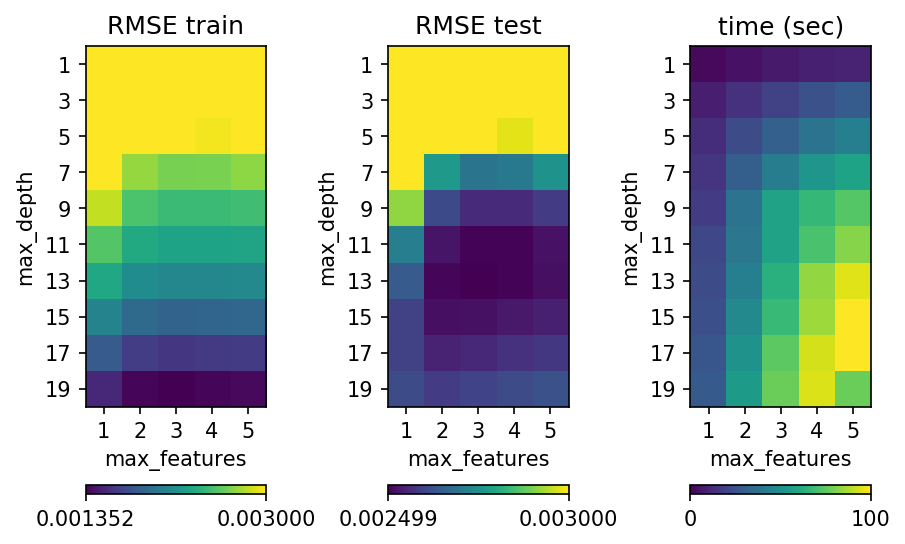

In [111]:
param = GridSearchRF.cv_results_['param_max_features'].data
mean_train = -GridSearchRF.cv_results_['mean_train_score']
mean_test = -GridSearchRF.cv_results_['mean_test_score']
std_train = GridSearchRF.cv_results_['std_train_score']
std_test = GridSearchRF.cv_results_['std_test_score']
mean_time = GridSearchRF.cv_results_['mean_fit_time']
std_time = GridSearchRF.cv_results_['std_fit_time']

fig,axes = pl.subplots(1,3)
im0 = axes[0].imshow(mean_train.reshape(-1,5),vmin=mean_train.min(),vmax=0.003)
pl.colorbar(im0,orientation='horizontal',ax=axes[0],ticks=[im0.norm.vmin,im0.norm.vmax])
axes[0].set_title('RMSE train')
im1 = axes[1].imshow(mean_test.reshape(-1,5),vmin=mean_test.min(), vmax=0.003)
pl.colorbar(im1,orientation='horizontal',ax=axes[1],ticks=[im1.norm.vmin,im1.norm.vmax])
axes[1].set_title('RMSE test')
im2 = axes[2].imshow(mean_time.reshape(-1,5),vmin=0.,vmax=100)
pl.colorbar(im2,orientation='horizontal',ax=axes[2],ticks=[im2.norm.vmin,im2.norm.vmax])
axes[2].set_title('time (sec)')
for ax in axes:
    ax.set_xticks(np.array(param_grid[0]['max_features'])-1)
    ax.set_yticks(np.array(param_grid[0]['max_depth'])/2.-0.5)
    ax.set_xticklabels(param_grid[0]['max_features'])
    ax.set_yticklabels(param_grid[0]['max_depth'])
    ax.set_xlabel('max_features')
    ax.set_ylabel('max_depth')
pl.tight_layout()


In [112]:
for key, value in best_params.items():
    print("{:<30}:{}".format(key, value))

max_depth                     :13
max_features                  :3


CPU times: user 1min 1s, sys: 436 ms, total: 1min 1s
Wall time: 11.6 s
CPU times: user 216 ms, sys: 37 ms, total: 253 ms
Wall time: 110 ms


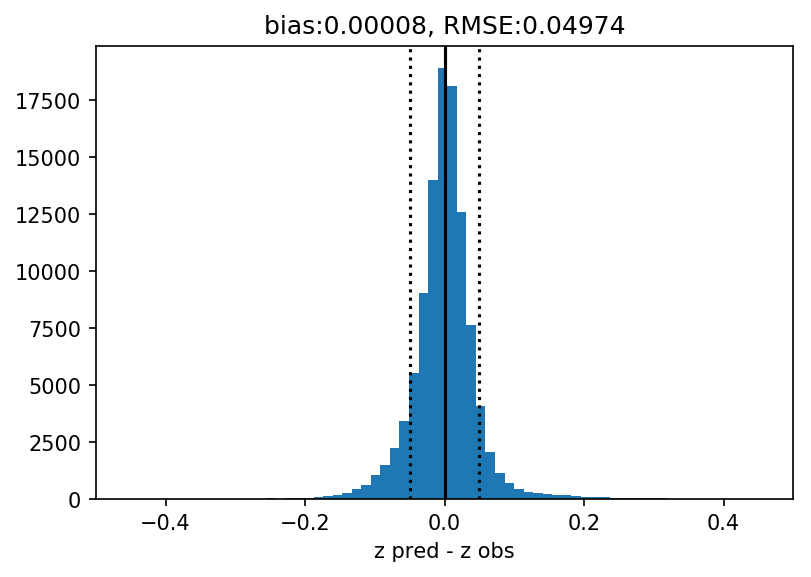

In [113]:
np.random.seed(1234)
rf = RandomForestRegressor(n_estimators=10,max_depth=best_params['max_depth'],max_features=best_params['max_features'], n_jobs=8, random_state=1234)

%time fit = rf.fit(X_train, y_train)
%time y_pred = rf.predict(X_test)

diff = y_pred-y_test
bias = np.mean(diff)
rmse = np.sqrt(np.mean(diff**2))
rmse_optimised = rmse.copy()

pl.hist(diff, bins=100)
pl.axvline(bias,color='k')
pl.axvline(bias-rmse_optimised,color='k',ls=':')
pl.axvline(bias+rmse_optimised,color='k',ls=':')
pl.xlim([-0.5,0.5])
pl.xlabel("z pred - z obs")
pl.title("bias:{:6.5f}, RMSE:{:4.5f}".format(bias, rmse_optimised))
pl.show()

## Improvement


In [114]:
print("For 10 trees a {:5.2f}% improvement from standard RF parameters".format(100*(1-rmse_optimised/rmse_default)))

For 10 trees a  6.07% improvement from standard RF parameters


CPU times: user 22min 9s, sys: 6.95 s, total: 22min 16s
Wall time: 3min 13s
CPU times: user 3.73 s, sys: 69.7 ms, total: 3.8 s
Wall time: 515 ms


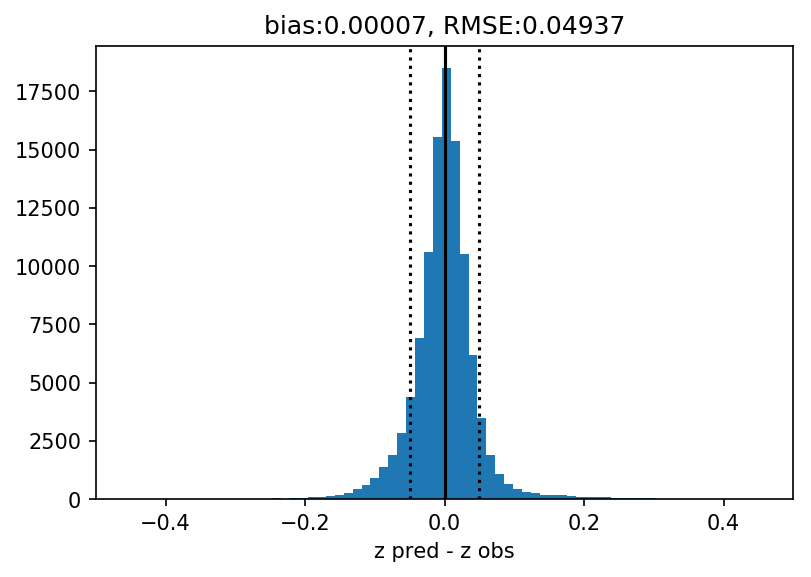

In [115]:
np.random.seed(1234)
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(n_estimators=200,max_depth=best_params['max_depth'],max_features=best_params['max_features'], n_jobs=8, random_state=1234)

%time fit = rf.fit(X_train, y_train)
%time y_pred = rf.predict(X_test)

diff = y_pred-y_test
bias = np.mean(diff)
rmse = np.sqrt(np.mean(diff**2))
rmse_optimised_many_trees = rmse.copy()

pl.hist(diff, bins=100)
pl.axvline(bias,color='k')
pl.axvline(bias-rmse,color='k',ls=':')
pl.axvline(bias+rmse,color='k',ls=':')
pl.xlim([-0.5,0.5])
pl.xlabel("z pred - z obs")
pl.title("bias:{:6.5f}, RMSE:{:4.5f}".format(bias, rmse))
pl.show()

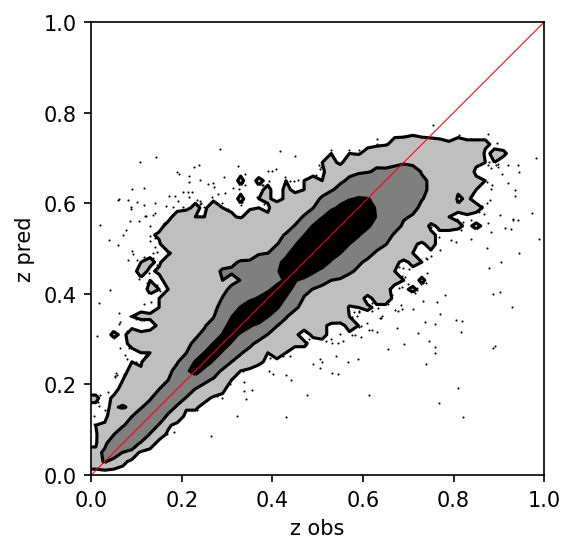

In [118]:
fig, ax = pl.subplots()
hist2d(y_test,y_pred,bins=50,ax=ax,range=[[0,1],[0,1]],levels=[0.68,0.95,0.997],plot_density=False,fill_contours=True,data_kwargs={'alpha':1,'marker':'.'})
ax.set_aspect('equal')
ax.set_ylabel("z pred")
ax.set_xlabel("z obs")
pl.plot([0,1],[0,1],'r-',lw=0.5)
pl.show()

## Final improvement


In [127]:
print("For a forest of {} trees and optimised parameters:\n - {:5.2f}% improvement from standard RF parameters \n - {:5.2f}% improvement from a linear model.".format(rf.get_params()['n_estimators'],100*(1-rmse_optimised_many_trees/rmse_default),100*(1-rmse_optimised_many_trees/rmse_linear)))

For a forest of 200 trees and optimised parameters:
 -  6.76% improvement from standard RF parameters 
 - 17.06% improvement from a linear model.


# Interpreting results
## Feature importance

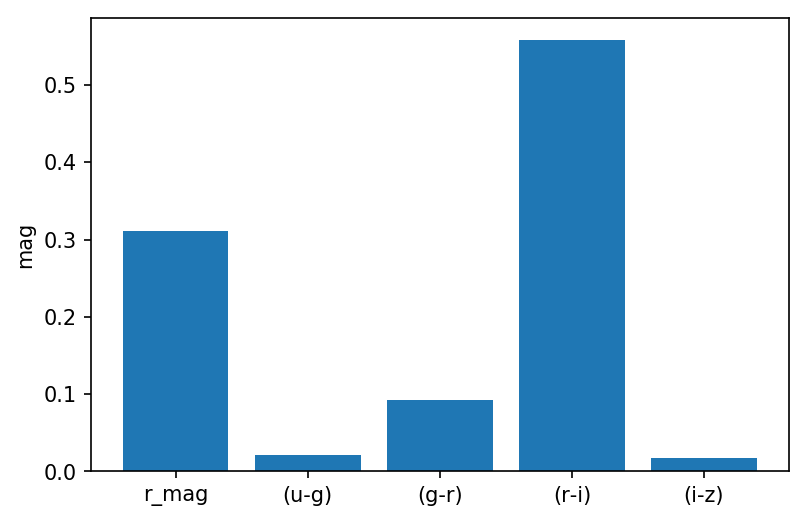

In [128]:
pl.bar(range(5),rf.feature_importances_)
pl.ylabel('mag')
pl.xticks([0,1,2,3,4],t.colnames[1:])
pl.xticks
pl.show()

# Interpreting results
## Individual contribution

In [129]:
from treeinterpreter import treeinterpreter as ti
nsamples = 5
lowz_features = X_test[y_test<0.1][:nsamples]
lowz_specz = y_test[y_test<0.1][:nsamples]

highz_features = X_test[y_test>0.8][:nsamples]
highz_specz = y_test[y_test>0.8][:nsamples]
format_str = "spec z:{:5.2f}    photo z:{:5.2f} = {:5.2f} + {:5.2f} x " + " + {:5.2f} x ".join(t.colnames[1:6])
prediction, bias, contributions = ti.predict(rf, lowz_features)
for o, p, b, c in zip(lowz_specz, prediction, bias, contributions):
    print(format_str.format(o,p,b,*c))
print("")
prediction, bias, contributions = ti.predict(rf, highz_features)
for o, p, b, c in zip(lowz_specz, prediction, bias, contributions):
    print(format_str.format(o,p,b,*c))


spec z: 0.08    photo z: 0.10 =  0.45 + -0.14 x r_mag +  0.00 x (u-g) + -0.08 x (g-r) + -0.12 x (r-i) + -0.01 x (i-z)
spec z: 0.09    photo z: 0.09 =  0.45 + -0.14 x r_mag +  0.01 x (u-g) + -0.10 x (g-r) + -0.12 x (r-i) + -0.00 x (i-z)
spec z: 0.10    photo z: 0.13 =  0.45 + -0.14 x r_mag + -0.00 x (u-g) + -0.05 x (g-r) + -0.12 x (r-i) + -0.01 x (i-z)
spec z: 0.09    photo z: 0.35 =  0.45 + -0.01 x r_mag +  0.05 x (u-g) + -0.10 x (g-r) +  0.00 x (r-i) + -0.04 x (i-z)
spec z: 0.08    photo z: 0.08 =  0.45 + -0.14 x r_mag + -0.00 x (u-g) + -0.10 x (g-r) + -0.12 x (r-i) + -0.00 x (i-z)

spec z: 0.08    photo z: 0.70 =  0.45 +  0.03 x r_mag +  0.02 x (u-g) +  0.12 x (g-r) +  0.08 x (r-i) + -0.00 x (i-z)
spec z: 0.09    photo z: 0.66 =  0.45 +  0.05 x r_mag + -0.00 x (u-g) + -0.01 x (g-r) +  0.17 x (r-i) +  0.00 x (i-z)
spec z: 0.10    photo z: 0.62 =  0.45 +  0.10 x r_mag +  0.16 x (u-g) +  0.07 x (g-r) + -0.21 x (r-i) +  0.04 x (i-z)
spec z: 0.09    photo z: 0.34 =  0.45 +  0.04 x r_mag +

# Going further
## Being wary of extrapolation
Your data live in a lower dimentional subset of the parameter space

In [ ]:
from sklearn.ensemble import IsolationForest
IF = IsolationForest(n_jobs=8,random_state=1234)
IF.fit(X_train)
outlier_prediction = IF.predict(X_test)

In [ ]:
print(IF.predict([[1,1,1,1,1],]))
print("Proportion of false negative: {:5.1f}%".format((outlier_prediction == -1).sum()/len(outlier_prediction) * 100))

# Going further
## Uncertainty on the prediction ?
Quantile regression

In [ ]:
from skgarden import RandomForestQuantileRegressor

In [ ]:
rfqr = RandomForestQuantileRegressor(max_depth=best_params['max_depth'],max_features=best_params['max_features'], n_jobs=8, random_state=1234)
%time fit = rfqr.fit(X_train, y_train)

In [ ]:
np.random.seed(1234)
nsample = 100
idx_subset = np.random.randint(0,len(X_test)+1,nsample)
sorted_idx_samples = np.argsort(y_test[idx_subset])
X_values = X_test[idx_subset][sorted_idx_samples]
y_values = y_test[idx_subset][sorted_idx_samples]

pred_med = rfqr.predict(X_values,quantile=50)
pred_1sigm = rfqr.predict(X_values,quantile=15.87)
pred_1sigp = rfqr.predict(X_values,quantile=84.13)
pred_2sigm = rfqr.predict(X_values,quantile=2.28)
pred_2sigp = rfqr.predict(X_values,quantile=97.73)

In [ ]:
pl.fill_between(range(nsample),pred_2sigm,pred_2sigp,color='C1',alpha=0.2,label='2sigma prediction interval')
pl.fill_between(range(nsample),pred_1sigm,pred_1sigp,color='C1',alpha=0.4,label='1sigma prediction interval')
pl.plot(range(nsample),y_values,'C0',marker='.',ls='none',label='spec z')
pl.plot(range(nsample),pred_med,'C1',label='median prediction')
pl.legend(loc='lower right')
pl.show()